# Project: No Show Appointment Data Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this project, a data set of appointment records in public hospitals at Vitoria, Brazil is investigated. The reason that affect the ability of a patient to miss the appointment attract our attention. This data set contains patient's record such as whether the patients show up, information about the appointment as well as the patient. 

Given the information and attributes about the patients with their scheduled appointment, how likely is a patient show up to the appoinment as scheduled? Throughout this project and a given data set, we are trying to answer this question by exploring the daat set as well as finding correlation between variables. 

### Questions:
(1) How is age affecting the patient's absense?

(2) Are no-show appointments associated with a certain gender?

(3) Does the age of patients affect the likelihood of no-show appointments?

(4) Does the time gap between scheduled day with appointment day affect the likelihood of now-show appointments?

In [212]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import datetime as dt0
% matplotlib inline
# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html


<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [213]:
# Read CSV and inspect columns
df = pd.read_csv('noshowappointment.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [214]:
df.shape

(110527, 14)

In [215]:
df.info() ## There is no null data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


Checking for any null values

In [216]:
df.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

### Data Cleaning

**Now that my data is loaded, I will make the following changes:**
- Checking for any duplicate rows
- Correct spelling for 'Hipertension' & 'Handcap' column headers
- Filter the data to only include patient older than 18 since minor patients tends to depend on their parents. 
- Remove 'appoinmentid', '' column since we don't need to used that info 
- Make the No-Show collumn to 'Attend' to avoid confusion as well as change its type to int64: 1 for attended and 0 for not attended
- Parsing appointment date and scheduled day into pandas datetime format and calculate the gap days between apointment time and schedule time

In [217]:
df.duplicated().sum() ## There is no duplicate 

0

In [218]:
## Correct speeling name
df.rename(columns={'Hipertension':'Hypertension', 'Handcap':'HandiCap', 'No-show':'Attend'}, inplace=True)
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,HandiCap,SMS_received,Attend
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [219]:
def parse_date(date):
    if date == "":
        return None
    return dt.strptime(date, '%Y-%m-%dT%H:%M:%SZ')

df['AppointmentDay'] = df['AppointmentDay'].apply(parse_date)
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,HandiCap,SMS_received,Attend
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [220]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay']).dt.date
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay']).dt.date
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,HandiCap,SMS_received,Attend
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [221]:
df.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hypertension        int64
Diabetes            int64
Alcoholism          int64
HandiCap            int64
SMS_received        int64
Attend             object
dtype: object

In [222]:
df['time-gap'] = df['AppointmentDay'] - df['ScheduledDay']
df.dtypes

PatientId                 float64
AppointmentID               int64
Gender                     object
ScheduledDay               object
AppointmentDay             object
Age                         int64
Neighbourhood              object
Scholarship                 int64
Hypertension                int64
Diabetes                    int64
Alcoholism                  int64
HandiCap                    int64
SMS_received                int64
Attend                     object
time-gap          timedelta64[ns]
dtype: object

In [223]:
def to_int(day):
    if day=="":
        return None
    return day.days

df['time-gap'] = df['time-gap'].apply(to_int)
df = df[df['time-gap']>=0]

In [224]:
df = df[df['Age']>=18]

In [225]:
df.drop(columns=['PatientId', 'AppointmentID', 'AppointmentDay', 'Neighbourhood'], inplace=True)
df.head()

,Gender,ScheduledDay,Age,Scholarship,Hypertension,Diabetes,Alcoholism,HandiCap,SMS_received,Attend,time-gap
0,F,2016-04-29,62,0,1,0,0,0,0,No,0
1,M,2016-04-29,56,0,0,0,0,0,0,No,0
2,F,2016-04-29,62,0,0,0,0,0,0,No,0
4,F,2016-04-29,56,0,1,1,0,0,0,No,0
5,F,2016-04-27,76,0,1,0,0,0,0,No,2


In [226]:
def is_attend(response):
    if response == 'Yes':
        return 0
    return 1

df['Attend'] = df['Attend'].apply(is_attend)

In [227]:
df.head()

,Gender,ScheduledDay,Age,Scholarship,Hypertension,Diabetes,Alcoholism,HandiCap,SMS_received,Attend,time-gap
0,F,2016-04-29,62,0,1,0,0,0,0,1,0
1,M,2016-04-29,56,0,0,0,0,0,0,1,0
2,F,2016-04-29,62,0,0,0,0,0,0,1,0
4,F,2016-04-29,56,0,1,1,0,0,0,1,0
5,F,2016-04-27,76,0,1,0,0,0,0,1,2


<a id='eda'></a>
## Exploratory Data Analysis

### Does the time gap between scheduled day with appointment day affect the likelihood of now-show appointments?

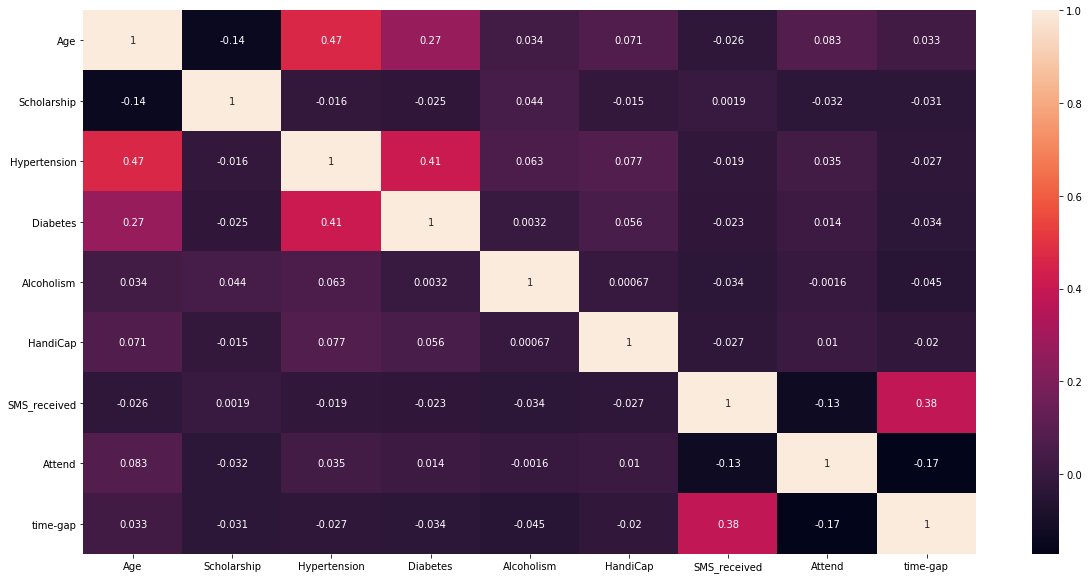

In [228]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), annot=True)
plt.show()

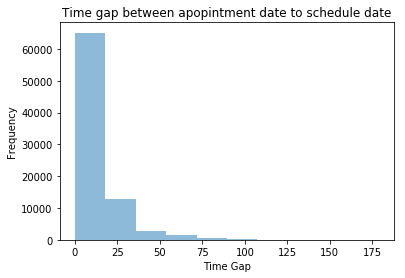

In [229]:
plt.hist(df['time-gap'], alpha=0.5)
plt.title('Time gap between apopintment date to schedule date')
plt.xlabel('Time Gap')
plt.ylabel('Frequency')
plt.legend()
plt.show()

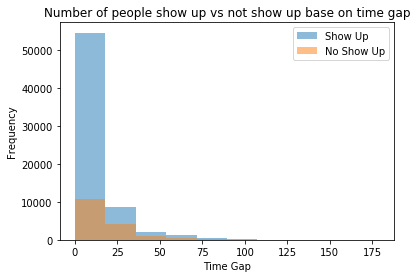

In [230]:
plt.hist(df[df['Attend']==1]['time-gap'], label='Show Up', alpha=0.5)
plt.hist(df[df['Attend']==0]['time-gap'], label='No Show Up', alpha=0.5)
plt.title('Number of people show up vs not show up base on time gap')
plt.xlabel('Time Gap')
plt.ylabel('Frequency')
plt.legend()
plt.show()

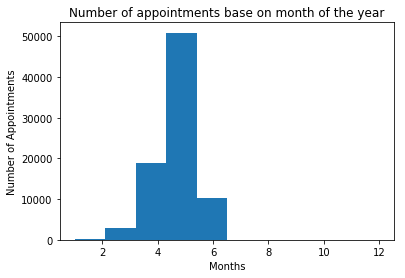

In [231]:
plt.hist(pd.to_datetime(df['ScheduledDay']).dt.month)
plt.title('Number of appointments base on month of the year')
plt.xlabel('Months')
plt.ylabel('Number of Appointments')
plt.legend()
plt.show()

- From the 3 charts above, we can conclude that people like to make appointment that is approximately 2 weeks prior to the scheduled day.
- The further the day / the further the time gap, people are more likely to miss their appointment.
- People are more likely to schedule an appointment in May.

### How is age affecting the patient's absense?

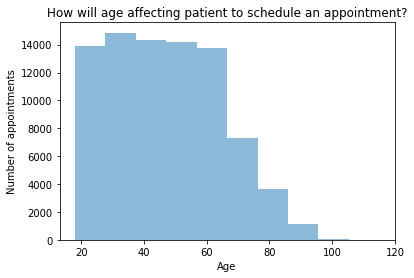

In [232]:
plt.hist(df['Age'], alpha=0.5)
plt.title('How will age affecting patient to schedule an appointment?')
plt.xlabel('Age')
plt.ylabel('Number of appointments')
plt.legend()
plt.show()

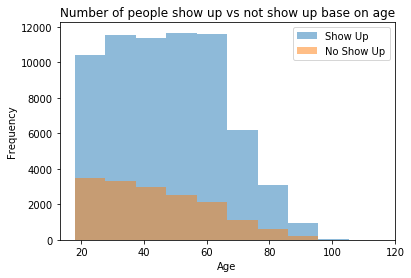

In [233]:
plt.hist(df[df['Attend']==1]['Age'], label='Show Up', alpha=0.5)
plt.hist(df[df['Attend']==0]['Age'], label='No Show Up', alpha=0.5)
plt.title('Number of people show up vs not show up base on age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()

- As patients are getting older, they are less likely to make an appointment
- Regardless of age, there is not a big different whether people will miss an appointment.

### Are no-show appointments associated with a certain gender?

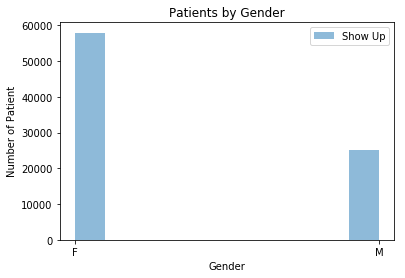

In [234]:
plt.hist(df['Gender'], label='Show Up', alpha=0.5)
plt.title('Patients by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Patient')
plt.legend()
plt.show()

In [235]:
male_attend = len(df[(df['Attend']==1) & (df['Gender']=='M')].index)
female_attend = len(df[(df['Attend']==1) & (df['Gender']=='F')].index)

male_missed = len(df[(df['Attend']==0) & (df['Gender']=='M')].index)
female_missed = len(df[(df['Attend']==0) & (df['Gender']=='F')].index)

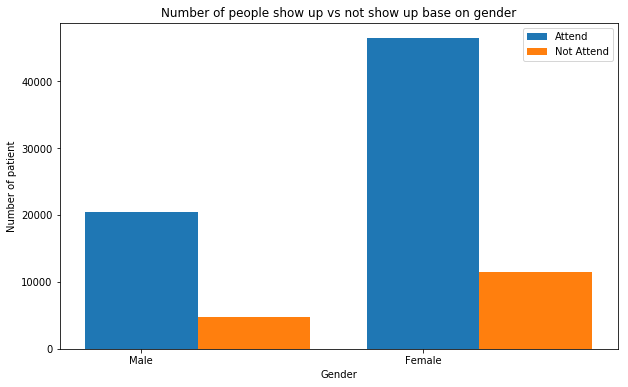

In [236]:
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(2)
b1 = ax.bar(x,height=[male_attend, female_attend], label='Attend', width=0.4)
b2 = ax.bar(x+0.4,height=[male_missed, female_missed], label='Not Attend', width=0.4)

ax.set_xticks([0,1])
ax.set_xticklabels(['Male', 'Female'])

plt.title('Number of people show up vs not show up base on gender')
plt.xlabel('Gender')
plt.ylabel('Number of patient')
plt.legend()
plt.show()


- The number of female patients is as twice as the number of male patients. 
- For both gender, about 1/4 of the patients who make an appointment fails to show up as scheduled

<a id='conclusions'></a>
## Conclusions

**Resullts**: Our data suggest that
1. The number of show up patients is 4 times higher than the number of no show up patients.The number of show up patients is always higher than no show up patients. Despite the factors, the ratio between show and no show remains unchanged. 
2. Patients are more likely to make an appointment in around summer time (From April to June) and are more likely to make an approximately 2 weeks ahead of their scheduled time. The model show that the longer the time is, the higher chance that patients will not show up as scheduled
3. The majority of the investigated patient is around 20 to 70 years old indicate that as patients get older, they are less likely to make an appointment. There is not big different base on age about whether the patients showed up to their appointment verse patients not showed up as scheduled
4. The number of female patients are as twice as the number of male patients
5. Regardless gender, patients that show up to their appointment as scheduled are 4 times higher than patients who don't show up. Therefore, like age, there is not a big different at all.

**Limitations**: There are a couple of limitations with our data
1. Most of our variables are categorical which does not allow for a high level of statistical method to used. The correlation matrix suggest that the correlation between factors verse 'attend' remain extremely low ( Can't prove a strong relationship which a low correlation ) 
2. There is not hypothesis as well as experiments being made in this investigated data
3. Most of our investigation factor is either 1 or 0 therefore we do not have much infomation about the condition of when and where the data is taken


In [237]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0